<a href="https://colab.research.google.com/github/csy99/dna-nn-theory/blob/master/lstm_ae_(2_layer)_chip(256).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import re
import time
# from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras

In [3]:
!pip install biopython
from Bio import SeqIO

     |████████████████████████████████| 2.3MB 4.6MB/s 


# Read Data

In [4]:
def readFasta(file):
  with open(file, 'r') as f:
    records = np.array([record.seq._data.upper() for record in SeqIO.parse(f, 'fasta')])
  with open(file, 'r') as f:
    records_id = np.array([record.id for record in SeqIO.parse(f, 'fasta')])
  print('reading', str(file), 'Number of sequences :', 
        len(records), 'Length of sequences :', len(records[0]))
  records_df = pd.DataFrame({'id': records_id, 'seq': records})
  return records_df

In [5]:
# read fasta data
data_path = '/content/gdrive/My Drive/Colab Notebooks/CHIP/'
chip_train = readFasta(data_path + 'train.fasta')
chip_val = readFasta(data_path + 'valid.fasta')
chip_test = readFasta(data_path + 'test.fasta')
chip_train["id"] = chip_train["id"].astype(int)
chip_val["id"] = chip_val["id"].astype(int)
chip_test["id"] = chip_test["id"].astype(int)
print(chip_train.id.value_counts())
print(chip_val.id.value_counts())
print(chip_test.id.value_counts())

reading /content/gdrive/My Drive/Colab Notebooks/CHIP/train.fasta Number of sequences : 77174 Length of sequences : 101
reading /content/gdrive/My Drive/Colab Notebooks/CHIP/valid.fasta Number of sequences : 1000 Length of sequences : 101
reading /content/gdrive/My Drive/Colab Notebooks/CHIP/test.fasta Number of sequences : 19544 Length of sequences : 101
1    38638
0    38536
Name: id, dtype: int64
1    500
0    500
Name: id, dtype: int64
0    9823
1    9721
Name: id, dtype: int64


In [ ]:
seq_num = 0
for seq in chip_train["seq"]:
  char_num = 0
  for char in seq:
    if char != 'A' and char != 'C' and char != 'T' and char != 'G':
      print("seq", seq_num, 'char', char_num, 'is', char)
    char_num += 1
  seq_num += 1

In [6]:
# check if the length of the sequence is the same 
seq_len = len(chip_train.seq[0])
print("The length of the sequence is", seq_len)
for seq in chip_train.seq[:200]:
  assert len(seq) == seq_len

The length of the sequence is 101


In [ ]:
# xtrain_full, xtest, ytrain_full, ytest = train_test_split(records_df, records_df.label, test_size=0.2, random_state=100, stratify=records_df.label)
# xtrain, xval, ytrain, yval = train_test_split(xtrain_full, ytrain_full, test_size=0.2, random_state=100, stratify=ytrain_full)
# print("shape of training, validation, test set\n", xtrain.shape, xval.shape, xtest.shape, ytrain.shape, yval.shape, ytest.shape)

In [7]:
word_size = 1
vocab = [''.join(p) for p in product('ACGT', repeat=word_size)]
vocab_size = len('ACGT')
print('vocab_size:', vocab_size)
# print("word_to_idx", word_to_idx)
create1gram = keras.layers.experimental.preprocessing.TextVectorization(
  standardize=lambda x: tf.strings.regex_replace(x, '(.)', '\\1 '), ngrams=1
)
create1gram.adapt(vocab)

vocab_size: 4


In [8]:
# the first two index of TextVectorization has been reserved to EOS and OOV
def index_preprocess(x):
  x_index = tf.subtract(create1gram(x), 2)
  return x_index, x_index

In [9]:
# not sure the correct way to get mapping from word to its index
create1gram('A C G T') - 2

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 2, 1, 0])>

In [10]:
BATCH_SIZE = 256
xtrain_seq = tf.data.Dataset.from_tensor_slices(chip_train['seq']).map(index_preprocess).batch(BATCH_SIZE)
xval_seq = tf.data.Dataset.from_tensor_slices(chip_val['seq']).map(index_preprocess).batch(BATCH_SIZE)
xtest_seq = tf.data.Dataset.from_tensor_slices(chip_test['seq']).map(index_preprocess).batch(BATCH_SIZE)

In [11]:
unit_size = 64
latent_size = 30

encoder = keras.Sequential([
    keras.Input(shape=(seq_len,)),
    keras.layers.Embedding(seq_len, unit_size),
    keras.layers.Bidirectional(keras.layers.LSTM(unit_size, return_sequences=True)),
    keras.layers.LSTM(latent_size, return_sequences=False),
])

decoder = keras.Sequential([
    keras.layers.RepeatVector(seq_len, input_shape=[latent_size]),
    keras.layers.LSTM(latent_size, return_sequences=True),
    keras.layers.LSTM(unit_size, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(4, activation='softmax'))  # ACTG
])

recurrent_ae = keras.Sequential([encoder, decoder])
recurrent_ae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 30)                91592     
_________________________________________________________________
sequential_1 (Sequential)    (None, 101, 4)            31900     
Total params: 123,492
Trainable params: 123,492
Non-trainable params: 0
_________________________________________________________________


In [13]:
# save_freq=1500 means that the model will be saved around every 20 epochs (each epochs contain 76 batches)
checkpoint_filepath = '/content/gdrive/My Drive/Colab Notebooks/models/lstm2_chip.256.{epoch:04d}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=False,
    save_freq=1500)
es_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [14]:
recurrent_ae.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
ae_hist = recurrent_ae.fit(xtrain_seq, validation_data=xval_seq, epochs=1000, callbacks=[es_cb])

Epoch 1/1000
302/302 [==============================] - 15s 50ms/step - loss: 1.3479 - accuracy: 0.3310 - val_loss: 1.3419 - val_accuracy: 0.3382
Epoch 2/1000
302/302 [==============================] - 14s 46ms/step - loss: 1.3373 - accuracy: 0.3448 - val_loss: 1.3340 - val_accuracy: 0.3490
Epoch 3/1000
302/302 [==============================] - 14s 46ms/step - loss: 1.3268 - accuracy: 0.3555 - val_loss: 1.3219 - val_accuracy: 0.3600
Epoch 4/1000
302/302 [==============================] - 14s 45ms/step - loss: 1.3165 - accuracy: 0.3650 - val_loss: 1.3067 - val_accuracy: 0.3714
Epoch 5/1000
302/302 [==============================] - 14s 47ms/step - loss: 1.2998 - accuracy: 0.3776 - val_loss: 1.2924 - val_accuracy: 0.3812
Epoch 6/1000
302/302 [==============================] - 14s 46ms/step - loss: 1.2859 - accuracy: 0.3869 - val_loss: 1.2785 - val_accuracy: 0.3913
Epoch 7/1000
302/302 [==============================] - 14s 46ms/step - loss: 1.2755 - accuracy: 0.3943 - val_loss: 1.2700 -

In [23]:
recurrent_ae.compile(optimizer=tf.optimizers.SGD(), loss='sparse_categorical_crossentropy', metrics='accuracy')
ae_hist2 = recurrent_ae.fit(xtrain_seq, validation_data=xval_seq, epochs=1000, callbacks=[es_cb])

Epoch 1/1000
302/302 [==============================] - 15s 51ms/step - loss: 1.3249 - accuracy: 0.3496 - val_loss: 1.3645 - val_accuracy: 0.3833
Epoch 2/1000
302/302 [==============================] - 15s 49ms/step - loss: 1.2502 - accuracy: 0.3851 - val_loss: 1.2200 - val_accuracy: 0.3951
Epoch 3/1000
302/302 [==============================] - 14s 46ms/step - loss: 1.2250 - accuracy: 0.3975 - val_loss: 1.1671 - val_accuracy: 0.4260
Epoch 4/1000
302/302 [==============================] - 14s 47ms/step - loss: 1.2140 - accuracy: 0.4045 - val_loss: 1.1538 - val_accuracy: 0.4343
Epoch 5/1000
302/302 [==============================] - 15s 48ms/step - loss: 1.2058 - accuracy: 0.4087 - val_loss: 1.1682 - val_accuracy: 0.4284
Epoch 6/1000
302/302 [==============================] - 14s 47ms/step - loss: 1.1987 - accuracy: 0.4129 - val_loss: 1.1637 - val_accuracy: 0.4280
Epoch 7/1000
302/302 [==============================] - 14s 48ms/step - loss: 1.1942 - accuracy: 0.4147 - val_loss: 1.1548 -

In [ ]:
# # can continue training
# loaded_ae_model = keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/models/lstm1_chip.0030.h5')
# reconstructed_encoder = keras.Model(loaded_ae_model.layers[0].input, loaded_ae_model.layers[0].output)
# reconstructed_decoder = keras.Model(loaded_ae_model.layers[1].input, loaded_ae_model.layers[1].output)
# reconstructed_autoencoder = keras.Sequential([reconstructed_encoder, reconstructed_decoder])
# reconstructed_autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
# ae_hist2 = reconstructed_autoencoder.fit(xtrain_seq, validation_data=xval_seq, epochs=200, callbacks=[es_cb,model_checkpoint_callback])

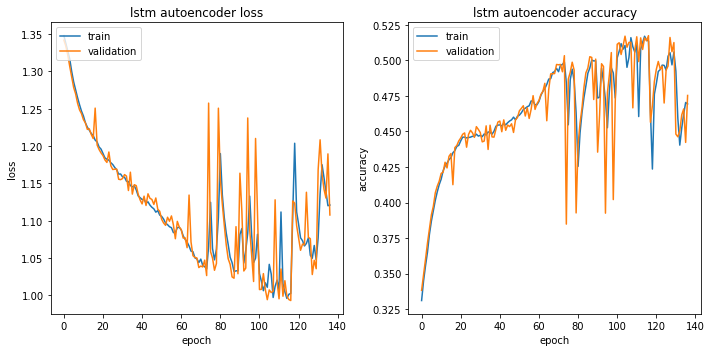

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(ae_hist.history['loss'], label='training')
  ax1.plot(ae_hist.history['val_loss'], label='validation')
  ax1.set_title('lstm autoencoder loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(ae_hist.history['accuracy'], label='training')
  ax2.plot(ae_hist.history['val_accuracy'], label='validation')
  ax2.set_title('lstm autoencoder accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()

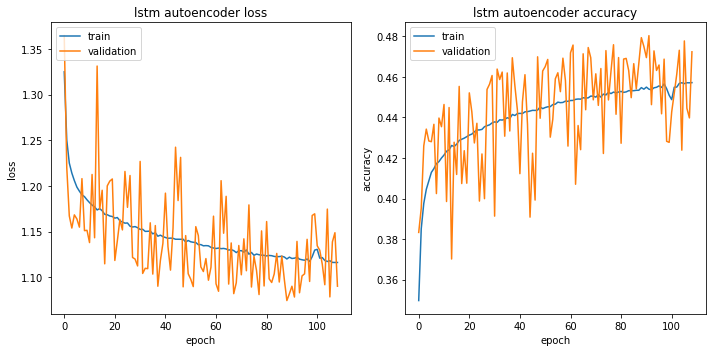

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(ae_hist2.history['loss'], label='training')
  ax1.plot(ae_hist2.history['val_loss'], label='validation')
  ax1.set_title('lstm autoencoder loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(ae_hist2.history['accuracy'], label='training')
  ax2.plot(ae_hist2.history['val_accuracy'], label='validation')
  ax2.set_title('lstm autoencoder accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()

In [16]:
# how to reconstruct the sequence
idx_to_char = {'0':'T', '1':'G', '2':'C', '3':'A'}
def show_reconstructions(model, x_seq=xtrain_seq, original_data=chip_train, samples=10):
  reconstructions = model.predict(x_seq)
  print('The shape of reconstructions', reconstructions.shape)
  recon_softmax = np.argmax(reconstructions, axis=-1)
  for i in range(samples):
    seq = ''
    for idx in recon_softmax[i]:
      seq += idx_to_char[str(idx)]
    print()
    print('The {}-th original sequence vs after reconstruction'.format(i))
    print(original_data['seq'].iloc[i])
    print(seq)

show_reconstructions(recurrent_ae, xval_seq, chip_val)

The shape of reconstructions (1000, 101, 4)

The 0-th original sequence vs after reconstruction
CATTGCAGTTCGTCTTAGCGCCGCCAGGCATGGTGTCCTGCATCACGGCCTCTTCCTGCACTGCTCCCTCTGCTGGCAGACCCCCTTCCCCTGCAGGTTCA
GGAGGAAGGGGGCCCCAGGCCCCCCGGGGAGGGGGCCCTGCAACCAGCCCCCCCCCTGAAGCCCCCCCCCGGCCCCCAACCCCCCCCCCCCTGCAGTTTCC

The 1-th original sequence vs after reconstruction
GGCCTGAGCTGCACAGGGGCCTGCTCAAATTTCTCCACTGGGCAGCACCATCGCCCAGAGGACCTGAAGAAAGCCTTCAGCTCCATTGACAGAGGCACTCT
CCCCGGAGCCCCCCAGGGGCCCTGGCAAGCCCCCCCCACGGGGGGGGGGAGGGCCCAGGGGCCCGGGAAAAAGCCCCCAGCCGGGGGGGGGAAGGCATTCT

The 2-th original sequence vs after reconstruction
ACTCTTTTGCTGGTGTTTCCCCGGTATCACACGTAGCCCTGCTTCCAGCTAGCCCAGTAGCACGGCTTGACACTCTGCTGGGTCGGGCATGACTTTCACTC
CCCCCCCTTGCCCCCCCCCCCTTCCAGCCCCGGCACCCTTGGTTTCAAGGGGGGAAAAGAACAGGGGCCAAGGGGGGGGGGGGGGGGGAGGCCATTTTATC

The 3-th original sequence vs after reconstruction
GTCAGGATAAACTAGTGCACAAACAGCCAAATTACCACTAGGGGGCCTGCCAGTCTCAAGAAAAATTTTGCGCGTCTGGGGAAAACTTGCTCATGGGACAG
AAAGAAAAAAACAGGGCCCCCCAAAGGCACCCCC

In [25]:
xtrain_vec = encoder.predict(xtrain_seq)
xval_vec = encoder.predict(xval_seq)
xtest_vec = encoder.predict(xtest_seq)
print('The shape of xtrain/xval/xtest_seq is', xtrain_vec.shape, xval_vec.shape, xtest_vec.shape)

The shape of xtrain/xval/xtest_seq is (77174, 30) (1000, 30) (19544, 30)


In [ ]:
# def plotVec(ax, x, y, title="title"):
#   scatter = ax.scatter(x[:, 0], x[:, 1], c=y, 
#              cmap=matplotlib.colors.ListedColormap(["red", "blue", "yellow"]))
#   ax.set_title(title)
#   ax.legend(*scatter.legend_elements(), loc=0, title="Classes")

In [ ]:
# # too many training example
# xtrain_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtrain_vec[:1000])
# xval_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xval_vec)
# xtest_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtest_vec[:1000])

# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# plotVec(axes[0], xtrain_tsne, chip_train[:1000]["id"], title="TSNE, training")
# plotVec(axes[1], xval_tsne, chip_val["id"], title="TSNE, validation")
# plotVec(axes[2], xtest_tsne, chip_test[:1000]["id"], title="TSNE, test")
# fig.tight_layout()

In [18]:
model = keras.models.Sequential([
  keras.layers.Dense(128, activation="relu", input_shape=[latent_size]),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(64, activation="relu"),    
  keras.layers.Dropout(0.2),
  keras.layers.Dense(32, activation="relu"),  
  keras.layers.Dropout(0.2), 
  keras.layers.Dense(16, activation="relu"), 
  keras.layers.Dropout(0.2),   
  keras.layers.Dense(1, activation="sigmoid")                               
])
model.compile(keras.optimizers.SGD(momentum=0.9), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model_hist = model.fit(xtrain_vec, chip_train['id'], validation_data=(xval_vec, chip_val['id']), epochs=200, callbacks=[es_cb])

Epoch 1/200
2412/2412 [==============================] - 6s 3ms/step - loss: 0.6732 - accuracy: 0.5830 - val_loss: 0.6673 - val_accuracy: 0.5870
Epoch 2/200
2412/2412 [==============================] - 6s 3ms/step - loss: 0.6723 - accuracy: 0.5833 - val_loss: 0.6734 - val_accuracy: 0.5610
Epoch 3/200
2412/2412 [==============================] - 6s 3ms/step - loss: 0.6708 - accuracy: 0.5858 - val_loss: 0.6707 - val_accuracy: 0.5870
Epoch 4/200
2412/2412 [==============================] - 6s 2ms/step - loss: 0.6705 - accuracy: 0.5863 - val_loss: 0.6710 - val_accuracy: 0.6100
Epoch 5/200
2412/2412 [==============================] - 6s 2ms/step - loss: 0.6703 - accuracy: 0.5871 - val_loss: 0.6718 - val_accuracy: 0.5840
Epoch 6/200
2412/2412 [==============================] - 6s 2ms/step - loss: 0.6695 - accuracy: 0.5900 - val_loss: 0.6665 - val_accuracy: 0.6110
Epoch 7/200
2412/2412 [==============================] - 6s 2ms/step - loss: 0.6687 - accuracy: 0.5905 - val_loss: 0.6720 - val_ac

In [20]:
def eval_model(model, x, true_label, ds_name="Training"):
  loss, acc = model.evaluate(x, true_label, verbose=0)
  print("{} Dataset: loss = {} and acccuracy = {}".format(ds_name, np.round(loss, 3), np.round(acc, 3)))

In [27]:
eval_model(model, xtrain_vec, chip_train["id"], "Training")
eval_model(model, xval_vec, chip_val["id"], "Validation")
eval_model(model, xtest_vec, chip_test["id"], "Test")

Training Dataset: loss = 0.661 and acccuracy = 0.601
Validation Dataset: loss = 0.665 and acccuracy = 0.597
Test Dataset: loss = 0.669 and acccuracy = 0.587


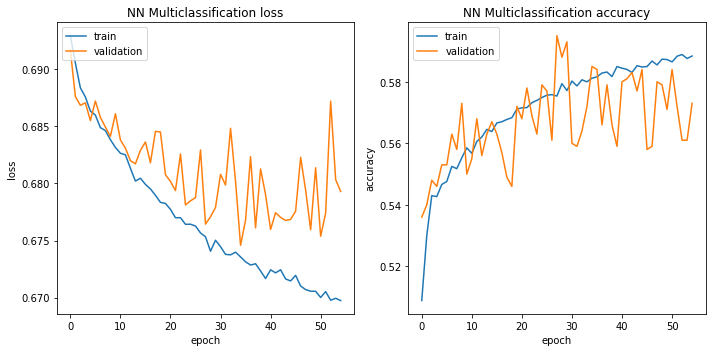

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(model_hist.history['loss'], label='training')
  ax1.plot(model_hist.history['val_loss'], label='validation')
  ax1.set_title('NN Multiclassification loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(model_hist.history['accuracy'], label='training')
  ax2.plot(model_hist.history['val_accuracy'], label='validation')
  ax2.set_title('NN Multiclassification accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()